<a href="https://colab.research.google.com/github/a-donat/Benchmarks_PyCaret/blob/main/Predicting_Firewall_Action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set-Up

## I.A. Import Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sgd825344491/internet-firewall
! unzip '/content/internet-firewall.zip' -d '/content/data'

In [ ]:
! pip install pycaret

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import VisualizeDataAbbrev as viz

import numpy as np
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split

## I.B. Load Data and Check Data Integrity

In [90]:
ds_df = pd.read_csv("/content/data/Firewall.csv")

In [91]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [92]:
ds_df["Action"].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [93]:
ds_df = ds_df[ds_df["Action"] != "reset-both"].copy()

In [94]:
ds_df.nunique()

Source Port             22692
Destination Port         3264
NAT Source Port         29143
NAT Destination Port     2533
Action                      3
Bytes                   10724
Bytes Sent               6683
Bytes Received           8814
Packets                  1116
Elapsed Time (sec)        915
pkts_sent                 749
pkts_received             922
dtype: int64

In [117]:
ds_df.groupby("Action")["Bytes"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,169038.0,7412625.0,60.0,194.0,422.0,5166.0,1.269359e+09
deny,14987.0,83.0,89.0,60.0,62.0,66.0,66.0,1.850000e+03
drop,12851.0,69.0,2.0,66.0,66.0,70.0,70.0,7.000000e+01


In [118]:
ds_df.groupby("Action")["Bytes Sent"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,38917.0,5051107.0,60.0,94.0,126.0,1586.0,948477220.0
deny,14987.0,83.0,87.0,60.0,62.0,66.0,66.0,1514.0
drop,12851.0,69.0,2.0,66.0,66.0,70.0,70.0,70.0


In [119]:
ds_df.groupby("Action")["Bytes Received"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,130121.0,3249056.0,0.0,91.0,220.0,3063.0,320881795.0
deny,14987.0,0.0,12.0,0.0,0.0,0.0,0.0,1419.0
drop,12851.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
ds_df.groupby("Action")["Packets"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,178.0,6772.0,1.0,2.0,3.0,19.0,1036116.0
deny,14987.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0
drop,12851.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [121]:
ds_df.groupby("Action")["Elapsed Time (sec)"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,115.0,392.0,0.0,27.0,30.0,49.0,10824.0
deny,14987.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
drop,12851.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
ds_df.groupby("Action")["Source Port"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,51128.0,12215.0,0.0,49418.0,53759.0,57369.0,65534.0
deny,14987.0,38557.0,21099.0,0.0,18754.0,46573.0,57356.0,65529.0
drop,12851.0,57038.0,4788.0,49156.0,52797.0,56846.0,61195.0,65533.0


In [115]:
ds_df.groupby("Action")["Destination Port"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,4728.0,12574.0,0.0,53.0,80.0,443.0,65535.0
deny,14987.0,33904.0,19337.0,0.0,22114.0,35440.0,50584.0,65504.0
drop,12851.0,445.0,0.0,445.0,445.0,445.0,445.0,445.0


In [116]:
pd.crosstab(ds_df["Destination Port"]==445, ds_df["Action"])

Action,allow,deny,drop
Destination Port,,,
False,37640,14947,0
True,0,40,12851


In [109]:
pd.crosstab(ds_df["NAT Source Port"]==0, ds_df["Action"])

Action,allow,deny,drop
NAT Source Port,,,
False,37076,12,0
True,564,14975,12851


In [111]:
pd.crosstab(ds_df["NAT Destination Port"]==0, ds_df["Action"])

Action,allow,deny,drop
NAT Destination Port,,,
False,37076,12,0
True,564,14975,12851


In [113]:
ds_df[ds_df["NAT Source Port"]==ds_df["NAT Destination Port"]].shape

(28390, 12)

In [114]:
pd.crosstab(ds_df["NAT Source Port"]==0, ds_df["NAT Destination Port"]==0)

NAT Destination Port,False,True
NAT Source Port,,
False,37088,0
True,0,28390


In [97]:
ds_df["Source Port"].value_counts()

58638    840
27005    513
443      273
57470    222
49418    210
        ... 
43163      1
41958      1
10005      1
64445      1
54871      1
Name: Source Port, Length: 22692, dtype: int64


# II. Preprocessing

In [122]:
train_df, test_df = train_test_split(
    ds_df, test_size=0.20, stratify=ds_df["Action"], random_state=1)

# III. Create Models

In [ ]:
# should be able to achieve 99.9% accuracy predicting action

In [126]:
exp_clf101 = setup(data=train_df, target = "Action", session_id=123,
                   fix_imbalance=True)


,Description,Value
0,Session id,123
1,Target,Action
2,Target type,Multiclass
3,Target mapping,"allow: 0, deny: 1, drop: 2"
4,Original data shape,"(52382, 12)"
5,Transformed data shape,"(78949, 12)"
6,Transformed train set shape,"(63234, 12)"
7,Transformed test set shape,"(15715, 12)"
8,Numeric features,11
9,Preprocess,True


In [127]:
best_model = compare_models(fold=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9992,0.9998,0.9992,0.9992,0.9992,0.9985,0.9985,2.1020
xgboost,Extreme Gradient Boosting,0.9990,0.9998,0.9990,0.9990,0.9990,0.9984,0.9984,12.2440
gbc,Gradient Boosting Classifier,0.9988,0.9995,0.9988,0.9988,0.9988,0.9980,0.9980,26.1840
rf,Random Forest Classifier,0.9987,0.9996,0.9987,0.9987,0.9987,0.9977,0.9977,4.2820
et,Extra Trees Classifier,0.9987,0.9996,0.9987,0.9987,0.9987,0.9977,0.9977,2.8480
dt,Decision Tree Classifier,0.9986,0.9992,0.9986,0.9986,0.9986,0.9976,0.9976,0.4380
knn,K Neighbors Classifier,0.9933,0.9980,0.9933,0.9934,0.9934,0.9885,0.9886,1.5960
lr,Logistic Regression,0.9901,0.9982,0.9901,0.9904,0.9901,0.9829,0.9831,11.2860
svm,SVM - Linear Kernel,0.9779,0.0000,0.9779,0.9791,0.9780,0.9620,0.9624,2.9500
nb,Naive Bayes,0.9620,0.9955,0.9620,0.9667,0.9628,0.9357,0.9378,0.6380


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

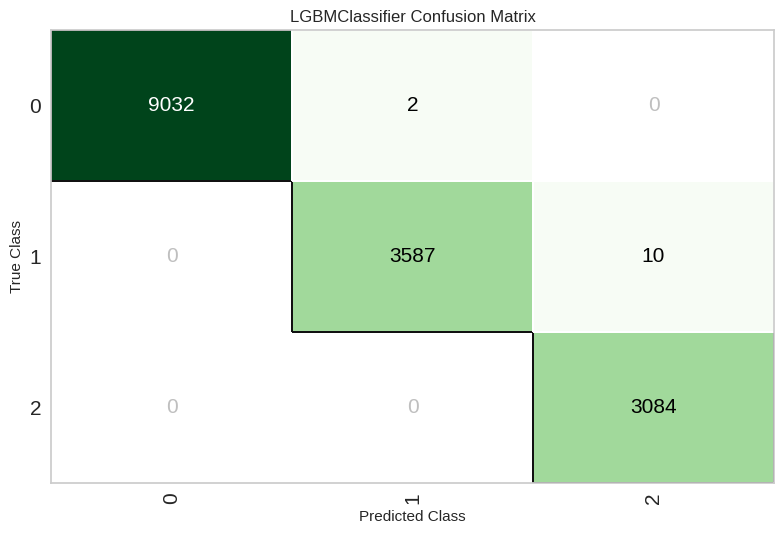

In [128]:
plot_model(best_model, plot = "confusion_matrix")